In [1]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm

import logging
logging.basicConfig(level = logging.DEBUG, format = '%(asctime)s - %(levelname)s - %(message)s')

%run generalized_open

In [2]:
def pull_file_info(user_file):
    
    import re


    pressure_regex = re.compile(r'\d{2,}m{2}Hg')
    distance_regex = re.compile(r'(\d+\.\d)cm')
    gas_regex_notAir = re.compile(r'[A,a]rgon|[H,h]elium')
    
    pressure_match = pressure_regex.search(user_file)
    pressure_units = pressure_match.group()
    pressure = pressure_units.strip('mmHg')
    pressure = int(pressure)
    
    distance_match = distance_regex.search(user_file)
    distance = distance_match.group()
    
    gas_match = gas_regex_notAir.search(user_file)
    
    if gas_match == None:
        gas = 'Air'
    else:
        gas = gas_match.group()
    
    console_result = 'gas: %s \ndistance = %s \npressure = %s'%(gas, distance, pressure_units)
    
    print(console_result)
    
    return (gas, distance, pressure)


In [3]:
def calibration_curve(x):
    return x * 0.013863 + (-0.313343)


In [4]:
def particle_energy(user_dir, user_file):
    
    (gas, distance, pressure) = pull_file_info(user_file)
    
    raw_data = my_open(user_dir, user_file)
    
    #list of signal + noise counts
    count_data = raw_data[12:len(raw_data) - 1]

    #array of signal + noise counts recorded in data file
    signal_and_noise = np.array(count_data, dtype = int)
    
    #educated guess based on height of outermost peaks surrounding maxima
    threshold = 7
    
    signal = []
    
    #strip noise based on threshold
    for dataPoint in signal_and_noise:
        if dataPoint > threshold:
            signal.append(dataPoint)
        else:
            signal.append(0)
            
    signal = np.array(signal, dtype = int)
    
    #largest count recorded
    max_amplitude = np.amax(signal)
    
    #index of maxima 
    mean_adjustment = np.argmax(signal)
    
    #calculate mean and standard deviation of the counts
    mean, std_dev = norm.fit(signal)
    
    channel = mean + mean_adjustment
    
    pcl_energy = calibration_curve(channel)
    
    downstream_channel = channel + std_dev
    
    downstream_energy = calibration_curve(downstream_channel)
    
    pcl_energy_error = downstream_energy - pcl_energy 
    
    
    print('particle energy:  %f (MeV)' %pcl_energy)
    print('particle energy error:  %f (MeV)' %pcl_energy_error)
    
    
    return (pcl_energy, pcl_energy_error, gas, distance, pressure)

2019-02-20 15:59:36,668 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_9.4cm_50mmHg.mca
2019-02-20 15:59:36,680 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_9.4cm_300mmHg.mca
2019-02-20 15:59:36,690 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_11.4cm_300mmHg.mca
2019-02-20 15:59:36,695 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_11.4cm_120mmHg.mca
2019-02-20 15:59:36,723 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_13.4cm_377mmHg.mca
2019-02-20 15:59:36,726 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_9.4cm_120mmHg.mca
2019-02-20 15:59:36,737 - DEBUG - file_path = /Users/nikourriola/Desktop/sp19/phys403/alpha/height_spectra_air/data_11.4cm_337mmHg.mca
2019-02-20 15:59:36,743 - DEBUG - file_path = /Users/nikour

gas: Air 
distance = 9.4cm 
pressure = 50mmHg
particle energy:  -0.170435 (MeV)
particle energy error:  0.057533 (MeV)
gas: Air 
distance = 9.4cm 
pressure = 300mmHg
particle energy:  -0.145376 (MeV)
particle energy error:  0.023157 (MeV)
gas: Air 
distance = 11.4cm 
pressure = 300mmHg
particle energy:  13.426555 (MeV)
particle energy error:  0.017524 (MeV)
gas: Air 
distance = 11.4cm 
pressure = 120mmHg
particle energy:  -0.146621 (MeV)
particle energy error:  0.006771 (MeV)
gas: Air 
distance = 13.4cm 
pressure = 377mmHg
particle energy:  5.801052 (MeV)
particle energy error:  0.010843 (MeV)
gas: Air 
distance = 9.4cm 
pressure = 120mmHg
particle energy:  -0.171653 (MeV)
particle energy error:  0.041706 (MeV)
gas: Air 
distance = 11.4cm 
pressure = 337mmHg
particle energy:  12.613512 (MeV)
particle energy error:  0.034726 (MeV)
gas: Air 
distance = 9.4cm 
pressure = 260mmHg
particle energy:  -0.144956 (MeV)
particle energy error:  0.027068 (MeV)
gas: Air 
distance = 11.4cm 
pressure 

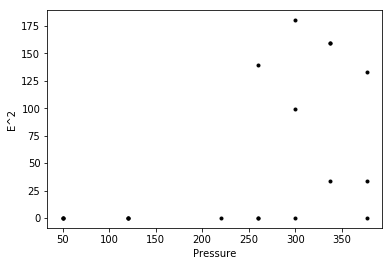

In [5]:
#air data sets
air_height_spectra = os.path.abspath('height_spectra_air')

energy_squared_air_list = []
pressure_list = []


for root, dirs, files in os.walk(air_height_spectra):
    for dataSet in files:
        summary = particle_energy(air_height_spectra, dataSet)
        
        energy_squared_air_list.append(summary[0]**2)
        pressure_list.append(summary[-1])
        
energy_squared_air = np.array(energy_squared_air_list)
pressure_array = np.array(pressure_list)

plt.plot(pressure_array, energy_squared_air, 'k.');
plt.xlabel('Pressure')
plt.ylabel('E^2')
plt.show()
        

In [26]:
pressure_array

array([ 50, 300, 300, 120, 377, 120, 337, 260, 260, 337, 300, 377,  50,
       220, 120, 377, 260, 337,  50])

In [27]:
energy_squared_air

array([2.90480772e-02, 2.11341720e-02, 1.80272384e+02, 2.14978560e-02,
       3.36522076e+01, 2.94648872e-02, 1.59100682e+02, 2.10123252e-02,
       9.81838356e-02, 1.59100682e+02, 9.92203369e+01, 1.32673598e+02,
       9.81838356e-02, 2.50689956e-02, 9.81838356e-02, 2.54303987e-02,
       1.39042496e+02, 3.38140270e+01, 3.01332586e-02])